В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

<span style="color:blue"> 0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів. </span> 

<span style="color:blue"> Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання. </span> 

In [13]:
!curl -O  https://raw.githubusercontent.com/BloomingPlum/machine_learning/main/process_bank_churn.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10045  100 10045    0     0  28037      0 --:--:-- --:--:-- --:--:-- 28295


In [14]:
from process_bank_churn import preprocess_data, preprocess_new_data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import os
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import time

In [15]:
raw_df = pd.read_csv('train.csv')
data = preprocess_data(raw_df, scaler_numeric=False)

In [16]:
X_train = data['train_X']
train_targets = data['train_y']
X_val = data['val_X']
val_targets = data['val_y']
encoder = data['encoder']
scaler = data['scaler']

In [17]:
X_train.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7180,682.0,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,1.0,0.0,0.0,1.0
10393,684.0,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,1.0,0.0,0.0,0.0
80,705.0,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0,1.0,0.0,1.0


<span style="color:blue"> 1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance? </span>  

In [8]:
# Створюємо об'єкт класифікатора KNN
knn = KNeighborsClassifier()

# Навчаємо модель на тренувальних даних:
knn.fit(X_train, train_targets)

# Передбачаємо ймовірності для тренувального і валідаційного наборів
train_preds = knn.predict_proba(X_train)[:, 1]
val_preds = knn.predict_proba(X_val)[:, 1]

# Обчислюємо AUROC
train_auroc = roc_auc_score(train_targets, train_preds)
val_auroc = roc_auc_score(val_targets, val_preds)

# Виводимо результати
print(f"AUROC на тренувальному наборі: {train_auroc:.4f}")
print(f"AUROC на валідаційному наборі: {val_auroc:.4f}")

AUROC на тренувальному наборі: 0.8237
AUROC на валідаційному наборі: 0.5734


AUROC for Training: 0.82


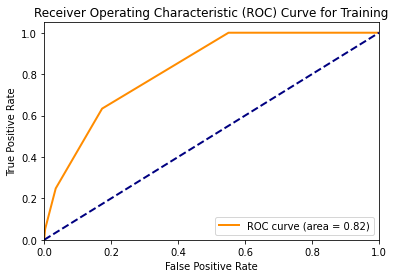

AUROC for Validation: 0.57


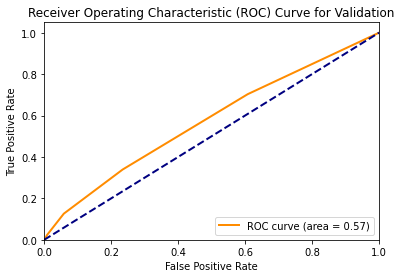

In [18]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = knn.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

<span style="color:green"> Показник AUROC на тренувальному датасеті значно вищий, ніж на валідаційному. Це свідчить про те, що модель має високу варіативність (high variance) і не є достатньо стійкою (robust). Вона добре запам’ятала тренувальні дані, але погано узагальнює закономірності для нових прикладів, що вказує на перенавчання (overfitting). </span>  

<span style="color:blue">  2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів. </span>  

<span style="color:blue">   Після успішного завершення пошуку оптимального гіперпараметра 
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ? </span>  


In [19]:
params_knn = {'n_neighbors': np.arange(1, 90)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)
knn_best = knn_gs.best_estimator_
print(knn_gs.best_params_, knn_gs.best_score_)

{'n_neighbors': 64} 0.7965833333333334


In [20]:
# Створюємо об'єкт класифікатора KNN
knn_64 = KNeighborsClassifier(n_neighbors=64)

# Навчаємо модель на тренувальних даних:
knn_64.fit(X_train, train_targets)

# Передбачаємо ймовірності для тренувального і валідаційного наборів
train_preds = knn_64.predict_proba(X_train)[:, 1]
val_preds = knn_64.predict_proba(X_val)[:, 1]

# Обчислюємо AUROC
train_auroc = roc_auc_score(train_targets, train_preds)
val_auroc = roc_auc_score(val_targets, val_preds)

# Виводимо результати
print(f"AUROC на тренувальному наборі: {train_auroc:.4f}")
print(f"AUROC на валідаційному наборі: {val_auroc:.4f}")

AUROC на тренувальному наборі: 0.6491
AUROC на валідаційному наборі: 0.6220


AUROC for Training: 0.65


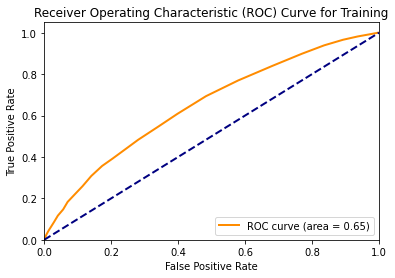

AUROC for Validation: 0.62


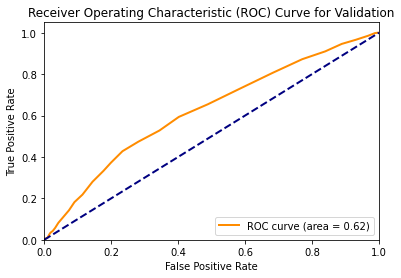

In [21]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = knn_64.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

<span style="color:green">  Нова модель не має явного overfitting (перенавчання), оскільки значення AUROC на тренувальних і валідаційних даних близькі. Проте загальний рівень AUROC досить низький, що вказує на high bias – модель недостатньо добре навчається і не вловлює важливі закономірності в даних. Дерево прийняття рішень з попереднього ДЗ справлялося з цим набагато краще. </span> 

<span style="color:blue">  3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів </span> 
- `max_depth` від 1 до 20 з кроком 2 
- `max_leaf_nodes` від 2 до 10 з кроком 1 <

<span style="color:blue">   Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`. </span> 

<span style="color:blue">   Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів. </span> 

<span style="color:blue">   Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну? </span> 

In [22]:
# Ініціалізація моделі з фіксованим random_state
dtc = DecisionTreeClassifier(random_state=42)

In [23]:
# Визначення сітки параметрів
params_dtc = {
    'max_depth': np.arange(1, 21, 2),
    'max_leaf_nodes': np.arange(2, 11, 1)
}

In [24]:
cv = RepeatedStratifiedKFold(n_splits=3, random_state=42)

In [25]:
# Створення об'єкта GridSearchCV
dtc_gs = GridSearchCV(
    estimator=dtc,
    param_grid=params_dtc,
    scoring='roc_auc',
    cv=cv,
)

In [26]:
# Вимірювання часу
start_time = time.time()
dtc_gs.fit(X_train, train_targets)
end_time = time.time()

In [27]:
# Вивід результатів
print(f"Час виконання GridSearchCV: {end_time - start_time:.2f} секунд")
print(f"Найкращі параметри: {dtc_gs.best_params_}")
print(f"Найкращий AUC-ROC: {dtc_gs.best_score_:.4f}")

Час виконання GridSearchCV: 33.81 секунд
Найкращі параметри: {'max_depth': 7, 'max_leaf_nodes': 10}
Найкращий AUC-ROC: 0.8998


In [28]:
# Збереження найкращої моделі
dt_best = dtc_gs.best_estimator_
dt_best 

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=10, random_state=42)

In [29]:
# Навчаємо модель на тренувальних даних:
dt_best.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=10, random_state=42)

In [30]:
# Оцінка якості на тренувальній та валідаційній вибірках
train_preds = dt_best.predict_proba(X_train)[:, 1]
val_preds = dt_best.predict_proba(X_val)[:, 1]

train_auroc = roc_auc_score(train_targets, train_preds)
val_auroc = roc_auc_score(val_targets, val_preds)

print(f"\nРезультати для GridSearchCV:")
print(f"Train AUC-ROC: {train_auroc:.4f}")
print(f"Val AUC-ROC: {val_auroc:.4f}")


Результати для GridSearchCV:
Train AUC-ROC: 0.9015
Val AUC-ROC: 0.9002


<span style="color:green"> Модель вже достатньо непогана, показник AUC-ROC виріс і майже не відрізняється в тренувальному і валідаційному датасетах. Однак, в попередньому завданні (decision trees) через loop вдалося знайти кращі параметри - там AUC-ROC на тестових даних був 0.91.  </span> 

<span style="color:blue"> 4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40. </span>  

<span style="color:blue">  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.</span>  

<span style="color:blue">  Після успішного завершення пошуку оптимальних гіперпараметрів </span>  
<span style="color:blue">    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.</span> 

In [31]:
# Ініціалізація моделі з фіксованим random_state
dt = DecisionTreeClassifier(random_state=42)

In [32]:
# Визначення розширеної сітки параметрів
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [33]:
cv = RepeatedStratifiedKFold(n_splits=3, random_state=42)

In [35]:
# Створення об'єкта RandomizedSearchCV
dt_rs = RandomizedSearchCV(
    dt,
    params_dt,
    n_iter=40,
    scoring='roc_auc',
    cv=cv,
    random_state=42,
)

In [36]:
# Вимірювання часу
start_time = time.time()
dt_rs.fit(X_train, train_targets)
end_time = time.time()

In [37]:
# Збереження найкращої моделі
dt_random_search_best = dt_rs.best_estimator_
dt_random_search_best

DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=42)

In [40]:
# Вивід результатів
print(f"\nЧас виконання RandomizedSearchCV: {end_time - start_time:.2f} секунд")
print(f"Найкращі параметри: {dt_rs.best_params_}")
print(f"Найкращий AUC-ROC: {dt_rs.best_score_:.4f}")


Час виконання RandomizedSearchCV: 9.63 секунд
Найкращі параметри: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}
Найкращий AUC-ROC: 0.9106


In [42]:
# Оцінка якості
train_preds_rs = dt_random_search_best.predict_proba(X_train)[:, 1]
val_preds_rs = dt_random_search_best.predict_proba(X_val)[:, 1]

train_auroc_rs = roc_auc_score(train_targets, train_preds_rs)
val_auroc_rs = roc_auc_score(val_targets, val_preds_rs)

print(f"\nРезультати для RandomizedSearchCV:")
print(f"Train AUC-ROC: {train_auroc_rs:.4f}")
print(f"Val AUC-ROC: {val_auroc_rs:.4f}")


Результати для RandomizedSearchCV:
Train AUC-ROC: 0.9169
Val AUC-ROC: 0.9166


<span style="color:green"> Модель, знайдена за допомогою RandomizedSearchCV, показала кращі результати, ніж та, яка була створена за допомогою GridSearchCV. Якщо порівняти параметри dt_random_search_best із dt_best, можна помітити, що dt_random_search_best має більше оптимізованих параметрів, що, ймовірно, і дозволило покращити її точність. </span>  

<span style="color:blue"> 5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче. </span> 

<span style="color:blue">   Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉  </span> 

In [43]:
model = DecisionTreeClassifier(
    criterion='entropy',
    splitter='best',
    max_depth=16,
    min_samples_split=20,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=42,
    max_leaf_nodes=14,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    ccp_alpha=0.0,
)

In [44]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=42)

In [45]:
test_df = pd.read_csv("test.csv")

preprocessed_test_df = preprocess_new_data(test_df, encoder, scaler, scaler_numeric=False)

In [46]:
preprocessed_test_df.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
0,584.0,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.0,1.0,0.0,1.0
1,551.0,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,1.0,0.0,0.0,1.0
2,706.0,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,1.0,0.0,0.0,1.0


In [47]:
probabilities = model.predict_proba(preprocessed_test_df)[:,1]

In [48]:
preprocessed_test_df["Exited"] = probabilities
preprocessed_test_df.describe().round(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,Exited
count,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.0000,1.000000e+04,10000.00000,10000.00000,10000.00000,10000.0000,10000.00000
mean,658.09150,37.88260,5.04200,42828.36645,1.58560,0.78030,0.4819,1.185294e+05,0.59550,0.18340,0.22110,0.5558,0.20675
std,72.16863,8.16614,2.79768,59904.66156,0.53094,0.41406,0.4997,7.558253e+04,0.49082,0.38701,0.41501,0.4969,0.28410
min,431.00000,18.00000,0.00000,0.00000,1.00000,0.00000,0.0000,4.477300e+02,0.00000,0.00000,0.00000,0.0000,0.01211
25%,602.00000,32.00000,3.00000,0.00000,1.00000,1.00000,0.0000,8.341915e+04,0.00000,0.00000,0.00000,0.0000,0.01211
50%,661.00000,37.00000,5.00000,0.00000,2.00000,1.00000,0.0000,1.229254e+05,1.00000,0.00000,0.00000,1.0000,0.05949
75%,708.00000,42.00000,7.00000,109927.33500,2.00000,1.00000,1.0000,1.557898e+05,1.00000,0.00000,0.00000,1.0000,0.23791
max,850.00000,74.00000,11.00000,186788.96000,4.00000,1.00000,1.0000,6.090906e+06,1.00000,1.00000,1.00000,1.0000,1.00000


In [49]:
#Подивимось скільки значень кожного класу передбачила модель на тестових даних 
rounded = preprocessed_test_df["Exited"].round()
counts = rounded.value_counts()
counts

0.0    8204
1.0    1796
Name: Exited, dtype: int64

In [50]:
submission_df = pd.read_csv("sample_submission.csv")

In [51]:
submission_df["Exited"] = preprocessed_test_df["Exited"]

In [52]:
submission_df.to_csv("submission__rand_search.csv", index=False)

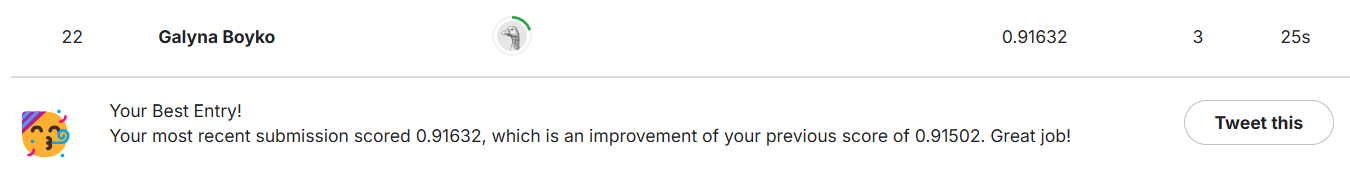